# **Traffic Sign Recognition using CNN**

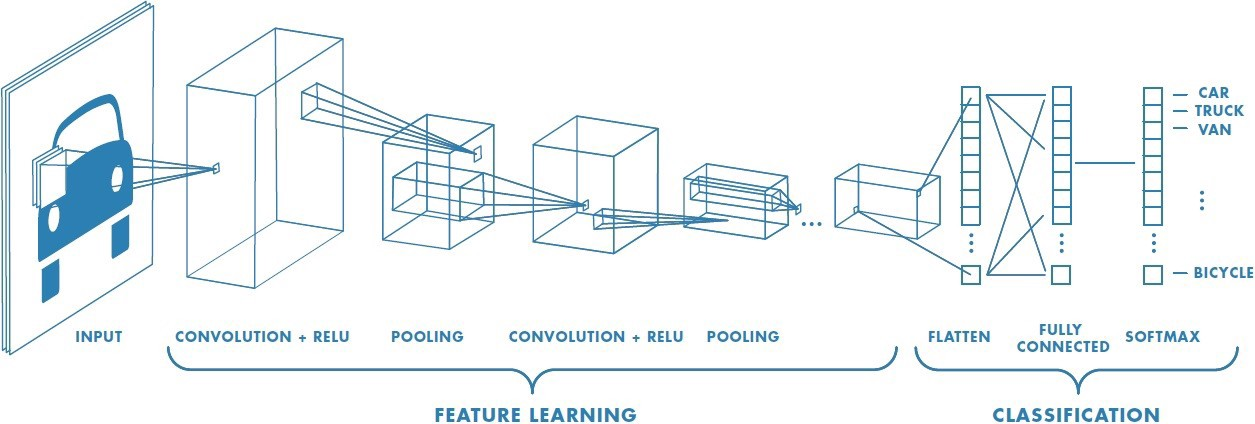

By: [Balamurugan P](https://www.linkedin.com/in/bala-murugan-62073b212/)

> **TASK** : To classify traffic signs into 43 distinct classes.

# **Data:**

> **Raw Data:** https://www.kaggle.com/flo2607/traffic-signs-classification<br><br>
> **Train-Val Split:** https://www.kaggle.com/balamurugan1603/traffic-signs-train-val-split

# **Dependencies:**

In [1]:
# Import dependencies
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model
from keras.callbacks import EarlyStopping

# **Doing a quick EDA:**

*EDA was done on data before splitting them into training and validation sets.*

In [2]:
# Path to raw data
data_path = "../input/traffic-signs-classification/myData"

# Listing sub directories
sub_directories = os.listdir(data_path)

# Loading labels
labels = pd.read_csv("../input/traffic-signs-classification/labels.csv")

In [3]:
# Finding number of classes in the data
print("Number of Classes: ",len(sub_directories))

In [4]:
# Finding number of images under each class
no_of_images = []
for directory in sub_directories:
    no_of_images.append(len(os.listdir(os.path.join(data_path, directory))))

labels["n_samples"] = no_of_images
labels.sort_values(["n_samples"], inplace=True)

# Displaying DataFrame containing class name, directory name and number of samples 
display(labels)

In [5]:
# Visualising number of samples under each class
f, ax = plt.subplots(figsize=(20, 7))
sns.barplot(x=labels["Name"], y=labels["n_samples"], palette="deep")
plt.xlabel("CLASS NAME")
plt.ylabel("NUMBER OF SAMPLES")
plt.xticks(rotation=90)
plt.show()

*From the visulization, It is clear that our dataset has class imbalance.*

In [6]:
# checking resolution of the images
res = cv2.imread(os.path.join(data_path, sub_directories[0], os.listdir(os.path.join(data_path, sub_directories[0]))[0])).shape
print("Height: ", res[0])
print("Width: ", res[1])
print("Number of Channels: ", res[2])
print("Resolution: {}x{}".format(res[0], res[1]))

In [7]:
# displaying some images randomly from each class
fig = plt.figure(figsize=(40, 30))
rows = 8
cols = 6
for directory in sub_directories:
    current_dir_files = os.listdir(os.path.join(data_path, directory))
    img = cv2.imread(os.path.join(data_path, directory, current_dir_files[random.randint(len(current_dir_files))]))
    fig.add_subplot(rows, cols, int(directory)+1)
    plt.imshow(img)
    plt.title(labels["Name"][int(directory)], fontsize=14)

# **Data Augmentation:**

*Before creating ImageDataGenerator object, We must prepare data which is compatible with ImageDataGenerator. So, I have created a different dataset where I have split the data into training and validation sets which is the one I used here.*

In [8]:
# Data Generators will augment the data and feed it to our models

train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             zoom_range=0.2,
                             fill_mode="nearest").flow_from_directory("../input/traffic-signs-train-val-split/traffic signs split/train",
                                                                      target_size=(32, 32),
                                                                      batch_size=32,
                                                                      class_mode="categorical")

val_datagen = ImageDataGenerator(rescale=1./255).flow_from_directory("../input/traffic-signs-train-val-split/traffic signs split/val",
                                                                     target_size=(32, 32),
                                                                     batch_size=32,
                                                                     class_mode="categorical")

# **Defining and Compiling the model:**

**Read About Convolutional Networks:**
<br>https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [9]:
# Function to create model
def create_model(activation="relu"):
    
    """ Creates and returns image classification model.
    
    Args:
        activation (str): Activation function to be used in first 
                          few layers.
    Returns:
        model (tensorflow model): Compiled image classification model.
    """
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation=activation, input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (3,3), activation=activation))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3,3), activation=activation))
    model.add(Flatten())
    model.add(Dense(512, activation=activation))
    model.add(Dense(256, activation="tanh"))
    model.add(Dense(128, activation="tanh"))
    model.add(Dense(43, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
# Creating model
TrafficSignRecogniser = create_model()

# Displays model architecture
TrafficSignRecogniser.summary()

# **Training the model:**

In [11]:
# Trains the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=100, patience=5)
history = TrafficSignRecogniser.fit_generator(train_datagen, validation_data=val_datagen, epochs=20, verbose=100, callbacks=[es])

# **Plotting the Error:**

In [12]:
# Plots training loss and validation loss from training history
history_dict = history.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# **Saving the model:**

In [13]:
# Saves the model
save_model(TrafficSignRecogniser, "TrafficSignRecogniser")